# **Streamplot of wind velocity**

Making a pretty static map of wind velocity, inspired by https://earth.nullschool.net/.
Using [Matplotlib](https://matplotlib.org) to derive the streamlines, and
[PyGMT](https://www.pygmt.org) for illustration of the background wind speed grid,
coastlines and streamlines.

References:
- https://matplotlib.org/3.8.3/plot_types/arrays/streamplot.html
- https://forum.generic-mapping-tools.org/t/someone-mentioned-flow-lines/2868
- https://github.com/cambecc/earth

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pygmt
import xarray as xr

## Load data from NetCDF file

Data processing steps:
1. Read data from the predicted output of the clifford_unet_uvsp_in1_out1 model
   (TODO add copy of file)
2. Subset time-series dataset to timestamp at t=0
3. Get DataArrays of zonal wind (U10M) and meridional wind (V10M),
   and calculate wind speed magnitude

Note that wind velocity values from this NetCDF are actually mean/std normalized values
from the neural network model, not actual wind velocities (but this is ok for
visualization purposes without a colorbar).

In [2]:
nc_file: str = "figures/predicted_SLP_U10M_V10M.nc"
ds_prediction: xr.Dataset = xr.open_dataset(filename_or_obj=nc_file)

# Subset to a specific datetime
timeval = ds_prediction.isel(time=0).time
timestr = str(timeval.dt.strftime(date_format="%Y-%m-%d %H:%M:%S").data)
ds_prd_t0 = ds_prediction.sel(time=timeval)

# Subset to a specific weather variable (SLP, U10M, or V10M)
da_prd_u10m: xr.DataArray = ds_prd_t0.sel(vars="U10M", drop=True)["var"].compute()
da_prd_v10m: xr.DataArray = ds_prd_t0.sel(vars="V10M", drop=True)["var"].compute()
da_prd_wspd: xr.DataArray = (da_prd_u10m**2 + da_prd_v10m**2) ** 0.5  # wind mag

assert da_prd_wspd.sizes["lat"] == 360
assert da_prd_wspd.sizes["lon"] == 576

# Print minimum and maximum wind speed value
da_prd_wspd.min().data, da_prd_wspd.max().data

(array(0.01170368, dtype=float32), array(30.344095, dtype=float32))

## Construct streamlines based on velocity grid

Using matplotlib's built-in streamplot function.

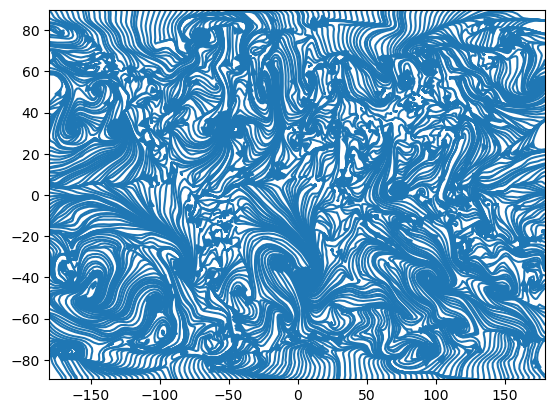

In [3]:
streamset: matplotlib.streamplot.StreamplotSet = plt.streamplot(
    x=da_prd_wspd.lon.data,
    y=da_prd_wspd.lat.data,
    u=da_prd_u10m.data,
    v=da_prd_v10m.data,
    density=3,
    minlength=0.1,
    maxlength=3.0,
    broken_streamlines=False,
)
line_paths: list[matplotlib.path.Path] = streamset.lines.get_paths()
# List of lines made up of xy points like [[(x0,y0), (x1, y1), ...], [(x10,y10), ...]]
lines: list[np.ndarray] = [path.vertices for path in line_paths]

## Prepare color palette table and grid for PyGMT

References:
- https://docs.generic-mapping-tools.org/6.5/reference/cpts.html
- https://www.pygmt.org/v0.11.0/api/generated/pygmt.GMTDataArrayAccessor.html

In [4]:
# Make color palette table
pygmt.makecpt(
    cmap="SCM/navia",
    series=[0, 20, 1],
    continuous=True,
    output="figures/cmap_wind_magnitude.cpt",
)

# Set grid registration and type before plotting with PyGMT
da_prd_wspd.encoding["source"] = None
da_prd_wspd.gmt.registration = 1  # Set to pixel registration
da_prd_wspd.gmt.gtype = 0  # Set to geographic type

## Plot wind speed with streamlines

Steps:
1. Plot wind speed grid on Orthographic projection
2. Plot coastlines with a faint thin line
3. Plot streamlines with a light gray colour and some transparency

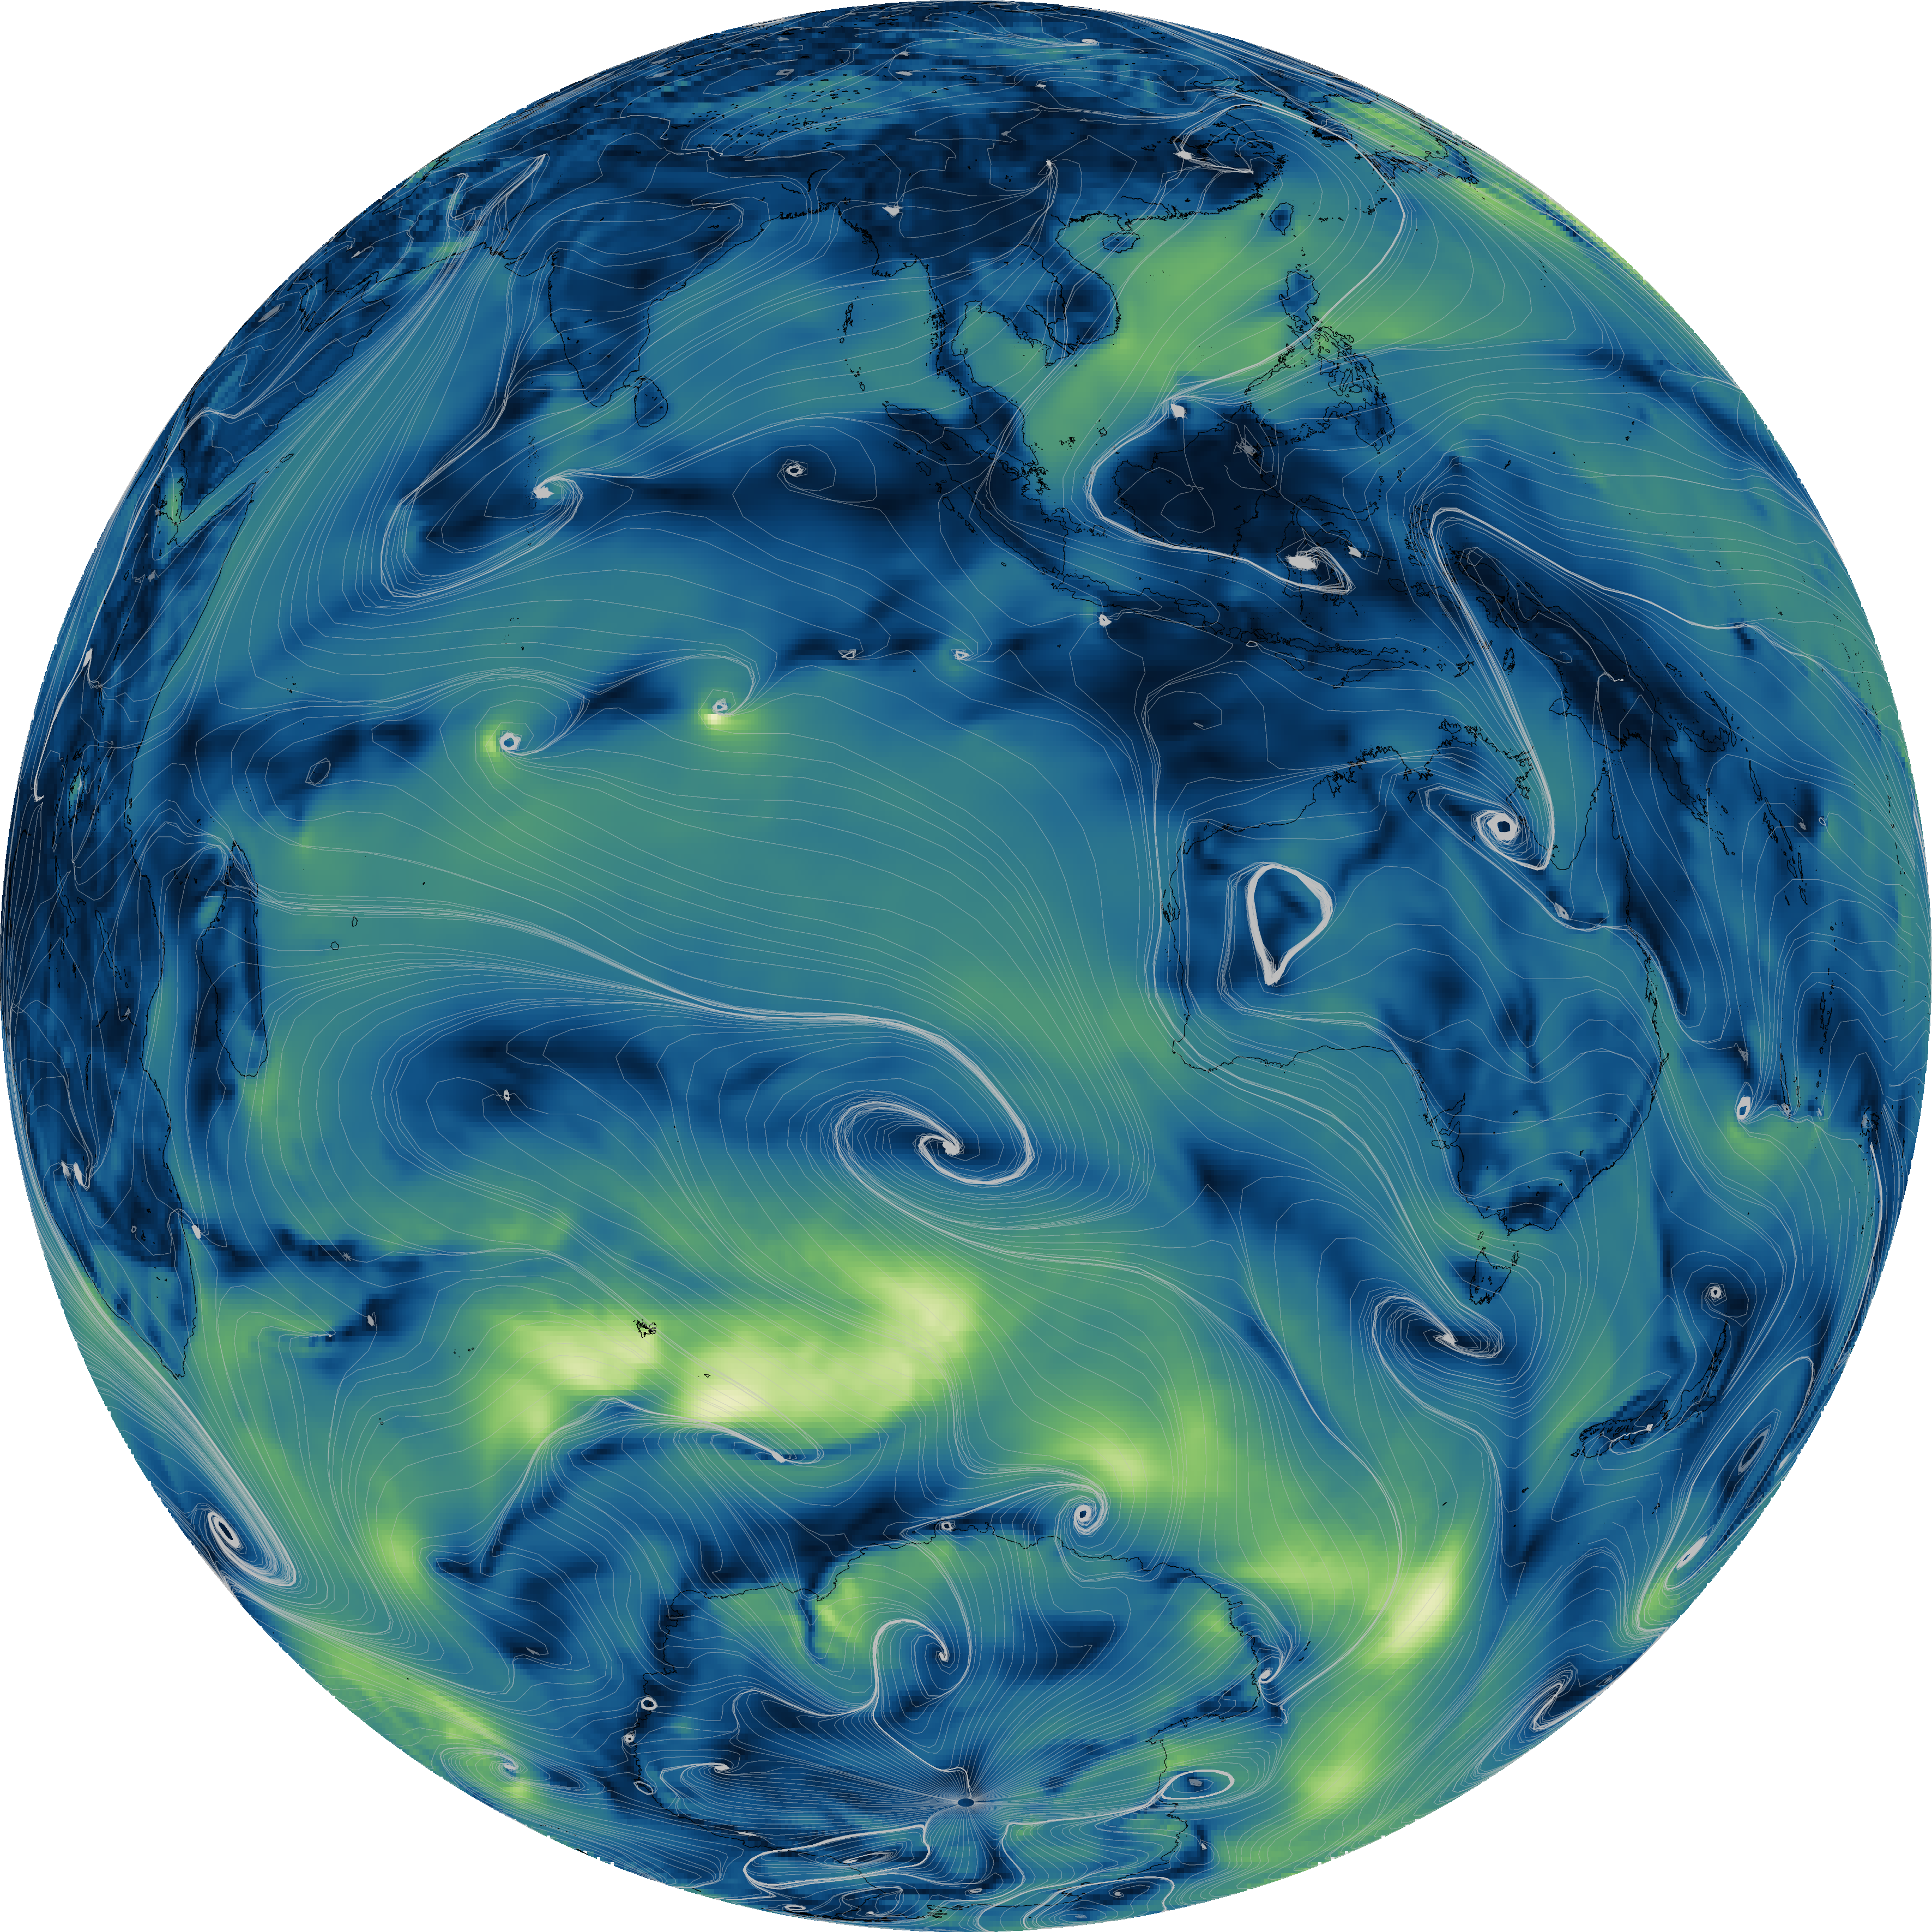

In [5]:
fig = pygmt.Figure()

fig.grdimage(
    grid=da_prd_wspd,
    cmap="figures/cmap_wind_magnitude.cpt",
    region=[-180, 180, -90, 90],
    projection="G100/-30/30c",  # Orthographic projection
)
fig.coast(shorelines="faint")
for line in lines:
    fig.plot(data=line, pen="0.05p,#bebebe,solid", transparency=45)

fig.show()

### Save figure in both PNG and PDF format

In [6]:
fig.savefig(fname="figures/key_figure.png", dpi=300)
fig.savefig(fname="figures/key_figure.pdf", dpi=600)